In [1]:
import os
import sys
sys.path.append('../')

import random as rn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import KFold

import tensorflow as tf

from src.utils.features import feature_names
from src.utils.models import train_and_pred
from src.utils.data import load_data

pd.options.display.max_columns = 100
%matplotlib inline
plt.style.use('seaborn')

/home/hardian_lawi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/fchollet/keras/issues/2280#issuecomment-306959926

def init_seeds(seed):

    os.environ['PYTHONHASHSEED'] = '0'

    # The below is necessary for starting Numpy generated random numbers
    # in a well-defined initial state.

    np.random.seed(seed)

    # The below is necessary for starting core Python generated random numbers
    # in a well-defined state.

    rn.seed(seed)

    # Force TensorFlow to use single thread.
    # Multiple threads are a potential source of
    # non-reproducible results.
    # For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

    from keras import backend as K

    # The below tf.set_random_seed() will make random number generation
    # in the TensorFlow backend have a well-defined initial state.
    # For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

    tf.set_random_seed(seed)

    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    
    K.set_session(sess)
    
    return sess

try:
    del sess
except:
    print('creating new session.')
    sess = init_seeds(0)

creating new session.


Using TensorFlow backend.


In [3]:
radiant_cols = ['hero_' + str(i) for i in range(5)]
dire_cols = ['hero_' + str(i) for i in range(5, 10)]
no_heroes = 116

radiants, dires, df = load_data()

In [4]:
def define_model(name='custom_nn_1', optimizer='adam', seed=0,
                 learning_rate=0.001, unit_size=16, activation='relu',
                 dropout_rate=0.2, alpha=0.01):

    if optimizer == 'adam':
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer = tf.train.GradientDescentOptimizer(
            learning_rate=learning_rate)
    else:
        raise Exception

    x = tf.keras.layers.Input(shape=[len(feature_names)], name='input')
    
    inputs = x
    
    if name == 'nn_tanh':
        x = tf.keras.layers.Dense(unit_size, activation='tanh')(x)
        x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    elif name == 'nn_relu':
        x = tf.keras.layers.Dense(unit_size, activation='relu')(x)
        x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    elif name == 'nn_l2_regularizer':
        x = tf.keras.layers.Dense(unit_size, activation=activation,
                                  kernel_regularizer=tf.keras.regularizers.l2(alpha))(x)
        x = tf.keras.layers.Dense(1, activation='sigmoid',
                                  kernel_regularizer=tf.keras.regularizers.l2(alpha))(x)
    elif name == 'nn_dropout':
        x = tf.keras.layers.Dropout(0.5, seed=seed)(x)
        x = tf.keras.layers.Dense(unit_size, activation=activation)(x)
        x = tf.keras.layers.Dropout(dropout_rate, seed=seed)(x)
        x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    else:
        raise Exception

    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(optimizer, loss='binary_crossentropy', metrics=['acc'])

    return model

In [5]:
n_splits = 5
kf = KFold(n_splits, shuffle=True, random_state=10)

print('=================================================')

avg_score = {}
scores = {}
avg_threshold = 0

histories = {}

for i, (train_idx, test_idx) in enumerate(kf.split(df)):
    
    X_train = radiants.iloc[train_idx].values - dires.iloc[train_idx].values
    X_test = radiants.iloc[test_idx].values - dires.iloc[test_idx].values

    y_train = df.radiant_win.iloc[train_idx].values
    y_test = df.radiant_win.iloc[test_idx].values
    
    print('Iter', i)
    print('Train pos pctg', y_train.mean())
    print('Test pos pctg', y_test.mean())
    print('-------------------------------------------------\n')
    
    models_dict = {
        'nn_tanh': [
            define_model(activation='tanh', name='nn_tanh', optimizer='adam', seed=0),
        ],
        'nn_relu': [
            define_model(activation='relu', name='nn_relu', optimizer='adam', seed=0),
        ],
        'nn_l2_regularizer': [
            define_model(activation='relu', name='nn_l2_regularizer', optimizer='adam', seed=0),
        ],
        'nn_dropout': [
            define_model(activation='relu', name='nn_dropout', optimizer='adam', seed=0),
        ],
    }
    
    if i not in histories:
        histories[i] = {}
        
    scores[i] = {}
    
    for key, models in models_dict.items():
        
        if key not in avg_score:
            avg_score[key] = dict(train=0, test=0)
            
        if key not in histories[i]:
            histories[i][key] = {}
            
        temp_preds = train_and_pred(models, X_train, y_train, X_test, y_test, key)
        temp_scores = accuracy_score(y_train, temp_preds[0] > 0.5), \
            accuracy_score(y_test, temp_preds[1] > 0.5)
        
        avg_score[key]['train'] += temp_scores[0]
        avg_score[key]['test'] += temp_scores[1]
        
        scores[i][key] = temp_scores[1]

        print(key, '==', 
              'train: %.4f' % temp_scores[0], '-',
              'test: %.4f' % temp_scores[1])
        
        histories[i][key].update(temp_preds[2].history)

    print('=================================================\n')
          
############################################################################

print('Average score\n--------------------')
for key, models in models_dict.items():
    print(key, '=======', 
          'train:', avg_score[key]['train'] / n_splits, '----',
          'test:', avg_score[key]['test'] / n_splits)

Iter 0
Train pos pctg 0.5376726663876099
Test pos pctg 0.5424863959815822
-------------------------------------------------

Instructions for updating:
Colocations handled automatically by placer.
nn_tanh == train: 0.6172 - test: 0.5598
nn_relu == train: 0.6089 - test: 0.5545
nn_l2_regularizer == train: 0.5693 - test: 0.5680
nn_dropout == train: 0.5719 - test: 0.5675

Iter 1
Train pos pctg 0.5393121250174411
Test pos pctg 0.5359285614622575
-------------------------------------------------

nn_tanh == train: 0.6190 - test: 0.5617
nn_relu == train: 0.6065 - test: 0.5613
nn_l2_regularizer == train: 0.5697 - test: 0.5643
nn_dropout == train: 0.5693 - test: 0.5549

Iter 2
Train pos pctg 0.5378121947816381
Test pos pctg 0.5419282824054695
-------------------------------------------------

nn_tanh == train: 0.6179 - test: 0.5567
nn_relu == train: 0.6054 - test: 0.5581
nn_l2_regularizer == train: 0.5677 - test: 0.5670
nn_dropout == train: 0.5707 - test: 0.5670

Iter 3
Train pos pctg 0.5390679

Text(0, 0.5, 'Validation Log loss')

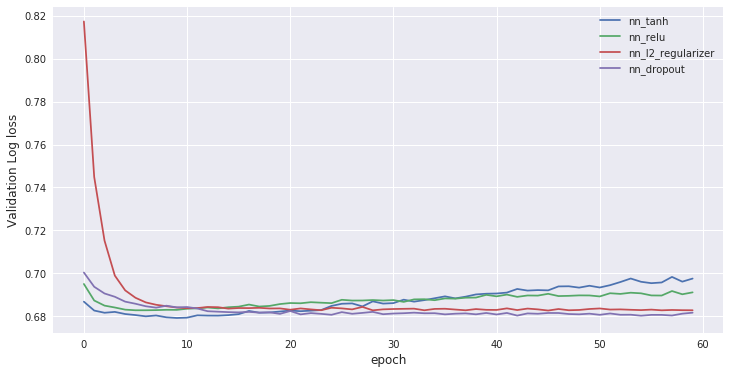

In [6]:
reform = {(metric, fold, model): values 
          for fold, interDict in histories.items() 
          for model, innerDict in interDict.items()
          for metric, values in innerDict.items()}

reform = pd.DataFrame(reform)

reform['val_loss'][0].plot(figsize=(12, 6))
plt.xlabel('epoch', fontsize=12)
plt.ylabel('Validation Log loss', fontsize=12)